# Tweets to Trades: Predicting Tesla Stock Buy Signals from Elon Musk's Twitter Activity

Project by **Simon Hoyos**

In this data science project, we aim to apply the power of natural language processing (NLP) and sentiment analysis to Elon Musk's Twitter user to generate buy signals for Tesla (`TSLA`) stock. Elon Musk, CEO of Tesla and a leading figure in the tech and business world, is known for his influential tweets and often motivates the market. By analyzing the sentiment and content of its tweets, we are trying to build predictive models that can help traders and investors make informed decisions about Tesla stock.

In [1]:
# Import the libraries needed for the project
import pandas as pd
import re
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils import resample


**Dataset:** This dataset comprises a collection of tweets posted by Elon Musk, spanning the years 2010 to 2021. Extracted from [Kaggle](https://www.kaggle.com/datasets/andradaolteanu/all-elon-musks-tweets/data)

In [2]:
# Load the tweets dataset as a dataframe
data = pd.read_csv('/content/drive/MyDrive/Bloomberg Portfolio/TweetsElonMusk.csv')

## 1. Data Cleaning and Preparation

### 1.1. Elon's Tweets

We will start by inspecting the data and the datatypes to select just the relevant columns.

In [3]:
data.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1381273474400800773,1381002894032347138,2021-04-11 18:50:33 EEST,2021-04-11,18:50:33,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'vincent13031925', 'name': 'V...",NaN,NaN,NaN,NaN
1,1381273076709478403,1372444955050971142,2021-04-11 18:48:58 EEST,2021-04-11,18:48:58,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
2,1381258144916008964,1381230136918433792,2021-04-11 17:49:38 EEST,2021-04-11,17:49:38,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'agnostoxxx', 'name': 'Shrubb...",NaN,NaN,NaN,NaN
3,1381221447322935303,1381221447322935303,2021-04-11 15:23:49 EEST,2021-04-11,15:23:49,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN
4,1381129584435818496,1381079981485252611,2021-04-11 09:18:47 EEST,2021-04-11,09:18:47,300,44196397,elonmusk,Elon Musk,NaN,...,NaN,NaN,NaN,NaN,NaN,"[{'screen_name': 'itsALLrisky', 'name': '💸💸💸',...",NaN,NaN,NaN,NaN


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12562 entries, 0 to 12561
Data columns (total 36 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               12562 non-null  int64  
 1   conversation_id  12562 non-null  int64  
 2   created_at       12562 non-null  object 
 3   date             12562 non-null  object 
 4   time             12562 non-null  object 
 5   timezone         12562 non-null  int64  
 6   user_id          12562 non-null  int64  
 7   username         12562 non-null  object 
 8   name             12562 non-null  object 
 9   place            0 non-null      float64
 10  tweet            12562 non-null  object 
 11  language         12562 non-null  object 
 12  mentions         12562 non-null  object 
 13  urls             12562 non-null  object 
 14  photos           12562 non-null  object 
 15  replies_count    12562 non-null  int64  
 16  retweets_count   12562 non-null  int64  
 17  likes_count 

In [5]:
# Create a copy of the columns with the date and the content of the tweet
clean_df=data[['date','tweet']].copy()

In [6]:
# Set 'date' as datetime format and sort the dataset according to the 'date'.
clean_df['date'] = pd.to_datetime(clean_df['date'])
clean_df = clean_df.sort_values('date')

There are no null values in the dataframe. Now, we will create a function to preprocess the tweets for NLP. The function aims to:


*   Remove hyperlinks
*   Remove special characters
*   Convert text to lowercase
*   Remove whitespaces




In [7]:
def preprocess_tweet(tweet):
    # Remove links
    tweet = re.sub(r'http\S+', '', tweet)
    # Remove special characters and numbers
    tweet = re.sub(r'[^a-zA-Z ]', '', tweet)
    # Convert text to lowercase
    tweet = tweet.lower()
    # Remove extra whitespaces
    tweet = ' '.join(tweet.split())
    return tweet

In [8]:
# Appply the function to all the 'tweet' column
clean_df['tweet']=clean_df[['tweet']].applymap(preprocess_tweet)

In [9]:
clean_df.head()

,date,tweet
12514,2010-06-04,please ignore prior tweets as that was someone...
12513,2011-12-01,went to iceland on sat to ride bumper cars on ...
12512,2011-12-01,i made the volume on the model s go to now i j...
12511,2011-12-03,great voltaire quote arguably better than twai...
12510,2011-12-03,that was a total non sequitur btw


### 1.2. Cleaning and preprocessing TSLA buy signals

We will define a buy signal as a day in which the stock grows more than 2%. For this we will use one-hot encoding representing a buying signal with a 1 and the absence of a buying signal with a 0.

First, we need to download TSLA price data and calculate the daily returns of the stock's closing price.

In [10]:
# Load TSLA stock data using yahoo finance
TSLA_df = yf.download('TSLA')

[*********************100%%**********************]  1 of 1 completed


In [11]:
# Calculate the returns as percentage change and remove the first null value
TSLA_df['Change'] = TSLA_df['Close'].pct_change()
TSLA_df.dropna(inplace=True)

Then, we define the buying signal as 2% growth and use boolean indexing to place 1 when growth is higher than 2% (signal).

In [12]:
strong_buy = 0.02
# Signal Column
TSLA_df['Buy Signal'] = (TSLA_df['Change'] > strong_buy).astype(int)

### 1.3. Merging both cleaned datasets and cleaning the merged dataset

In [13]:
# Creating a 'date' column on the TSLA_df dataframe to relate it with the 'date' column on 'clean_df'
TSLA_df['date']=TSLA_df.index

In [14]:
# Merging both dataframes on the 'date' column
merged_df = clean_df.merge(TSLA_df[['date', 'Buy Signal']], on='date', how='left')

In [15]:
merged_df.head()

,date,tweet,Buy Signal
0,2010-06-04,please ignore prior tweets as that was someone...,NaN
1,2011-12-01,went to iceland on sat to ride bumper cars on ...,0.0
2,2011-12-01,i made the volume on the model s go to now i j...,0.0
3,2011-12-03,great voltaire quote arguably better than twai...,NaN
4,2011-12-03,that was a total non sequitur btw,NaN


Some null values appear. A possible explanation for this null values is that Elon might have tweeted in non trading days. In this case, we will remove this tweets from the dataset for the simplification of the model. Another alternative would be to place the buying signal of the next trading day.

In [16]:
# Dropping null values
merged_df=merged_df.dropna()

Now, we need to check if the dataset is balanced.

In [17]:
merged_df['Buy Signal'].value_counts()

0.0    6302
1.0    2341
Name: Buy Signal, dtype: int64

Since the dataset is not balanced. It has more non buying signals than buying signals, we sill downsample non buying signals and upsample buying signals.

In [18]:
df_majority = merged_df[merged_df['Buy Signal']==0]
df_minority = merged_df[merged_df['Buy Signal']==1]
df_majority_downsampled = resample(df_majority, replace=False,n_samples=5000)
df_minority_upsampled = resample(df_minority, replace=True,n_samples=5000)
merged_df = pd.concat([df_majority_downsampled, df_minority_upsampled])

## 2. Model Preparation and Vectorization

We'll separate the dataset into features (X, representing the tweets) and labels (y, indicating Buy Signals). Then, we'll split the data into a training set and a testing set using an 80:20 ratio.

In [19]:
# Split the data into training and testing sets
X = merged_df['tweet']
y = merged_df['Buy Signal']  # 'label' should be 'buy', 'sell', or 'neutral'

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Use the TF-IDF (term frequency and inverse document frequency product) vectorizer for the processing of the Natural Language in the tweets.

In [20]:
# Create TF-IDF vector representations of the text
tfidf_vectorizer = TfidfVectorizer(stop_words='english', norm='l2') #norm used to equalize weights of long and short tweets. stop_words is used to remove common english words.
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [21]:
# Number of words (as features)
tfidf_vectorizer.get_feature_names_out().size

11023

## 3. Model Selection

### 3.1. Training a Neural Network

Now that we have all the data prepared and the vectorized features, lets fit a Multilayer Neural Network Classifier and evaluate it.

In [22]:
# Train a Neural Network
mlp = MLPClassifier(random_state=42)
mlp.fit(X_train_tfidf, y_train)

MLPClassifier(random_state=42)

In [23]:
# Make predictions
y_pred = mlp.predict(X_test_tfidf)

In [24]:
# Calculate the accurracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.781


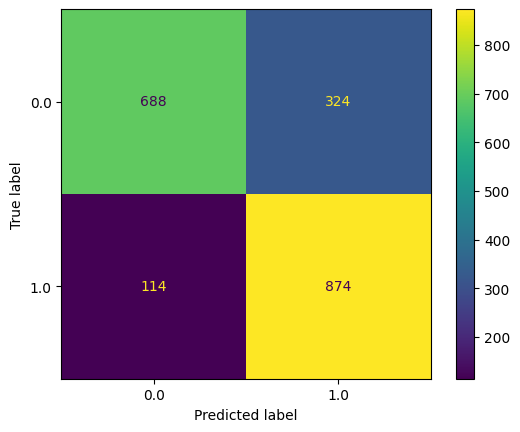

In [25]:
# Build a confusion matrix
confusion=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=mlp.classes_)
disp.plot()
plt.show()

An important factor to keep in mind is the **computer power** we have available. Because this model takes a long time to train and for hyperparameter tuning, our current computing capabilities might make it quite challenging to reach the best results. This limitation also restricts our ability to try out various combinations of hyperparameters and different neural network setups.

### 3.2. Training a Random Forest

Another alternative would be to train a random forest model wich helps reducing overfitting and requires usually less computational power than neural networks.

In [26]:
# Train a Random Forest
rf = RandomForestClassifier(criterion='gini', random_state=42)
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

Accuracy: 0.814


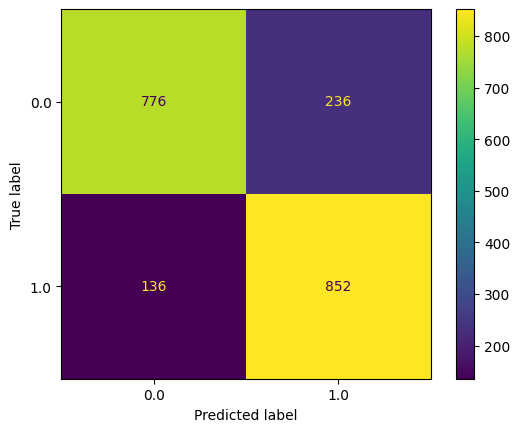

In [27]:
# Evaluation
y_pred = rf.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
confusion=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion, display_labels=rf.classes_)
disp.plot()
plt.show()

The Random Forest model shows a higher accurracy and a lower number of false positives which is great since it needs less computational power.

## 4. Model Optimization

In [28]:
# Apply the vectorizer to the complete X dataframe since we will use cross validation (no need for train_test split)
X = tfidf_vectorizer.transform(X)

To optimize the model we will run a grid search and cross validation to optimize the model precission.

In [49]:
# Define the hyperparameters and their possible values for the grid search
param_grid = {
    'max_depth': [None, 10, 30],       # Maximum depth of the trees
    'min_samples_split': [2, 5],      # Minimum samples required to split an internal node
}

In [50]:
# Create the Random Forest Classifier
rf_ = RandomForestClassifier()

In [51]:
# Create the GridSearchCV object
grid_search = GridSearchCV(rf_, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

In [52]:
# Fit the grid search to your data
grid_search.fit(X, y)  # X and y are your data and labels

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 30],
                         'min_samples_split': [2, 5]},
             scoring='accuracy')

In [53]:
print("Best Hyperparameters: ", grid_search.best_params_)

Best Hyperparameters:  {'max_depth': None, 'min_samples_split': 2}


## 5. Training the Optimal Model

We will proceed to train the optimal random forest classifier with the best hyperparameters according to the grid search above which are coincidentally the default values used in step 3.

In [56]:
# Train a Random Forest
rf_opt = RandomForestClassifier(max_depth= None, min_samples_split= 2, random_state=42)
rf_opt.fit(X_train_tfidf, y_train)

RandomForestClassifier(random_state=42)

In [58]:
# Predictions
y_pred = rf_opt.predict(X_test_tfidf)

In [59]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.77      0.81      1012
         1.0       0.78      0.86      0.82       988

    accuracy                           0.81      2000
   macro avg       0.82      0.81      0.81      2000
weighted avg       0.82      0.81      0.81      2000



To assess this trading strategy, which exclusively triggers long positions based on buy signals, it's essential to pay close attention to the **precision** score. This metric is instrumental in evaluating the strategy's accuracy in identifying profitable trades, as it quantifies the ratio of correct predictions of positive trades (i.e., gains) by measuring the number of true positive instances (valid buy signals) in relation to the total count of buy signals identified.

The percentage of winning trades assuming a long intraday strategy with this model would be: 78%

## 6. Predictions

To predict the effect of the tweet over the stock price, we will create a function that could be used to analyze every tweet.

In [119]:
def analyze_tweet(tweet_content):
  preprocessed_tweet = preprocess_tweet(tweet_content)
  proba_ = rf_opt.predict_proba(tfidf_vectorizer.transform([preprocessed_tweet]))
  prediction_ = rf_opt.predict(tfidf_vectorizer.transform([preprocessed_tweet]))
  print(f"The probability of having a strong buying signal according to the tweet is: {proba_[0][1] * 100:.2f}%")
  if prediction_==1:
    print("You should BUY TSLA Stock")
  else:
    print("Hold.")

In [120]:
analyze_tweet("Star light, star bright")

The probability of having a strong buying signal according to the tweet is: 73.38%
You should BUY TSLA Stock
